## Plot a window of Voice Activity Detection probability, and a highlighted section within it

In [12]:
import sys
sys.path.append("../scripts")

import matplotlib.pyplot as plt
import torch
import numpy as np
from pyannote.audio.core.io import Audio
from pyannote.audio import Model

test_file = "audio.wav"

In [2]:
# Run speech probability pripeline
audio = Audio(sample_rate=16000)
duration = audio.get_duration(test_file)
waveform, sample_rate = audio({"audio": test_file})
model = Model.from_pretrained("pyannote/segmentation",
                              use_auth_token="HUGGINGFACE_ACCESS_TOKEN")
with torch.no_grad():
    segmentation = model(waveform[np.newaxis]).numpy()[0]
speech_probability = np.max(segmentation, axis=-1, keepdims=True)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../home/sam/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/2ffce0501d0aecad81b43a06d538186e292d0070/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [75]:
from pathlib import Path
import sys
sys.path.append("../scripts")
from transcript_analysis import speech_proba

audio_filepath = Path("/mnt/c/Users/ssch7/repos/mums-voice/audio/AIM-3618/raw.wav")
speech_probability, duration, sample_rate = speech_proba(audio_filepath)
speech_activity_filepath = audio_filepath.parent / f"speech_probability.csv"
s_p_step = duration / len(speech_probability)
with open(speech_activity_filepath, 'w') as f:
    for i, row in enumerate(speech_probability):
        f.write(f"{i*s_p_step:.4f}s, {row[0]}\n")

import matplotlib.pyplot as plt
from pyannote.audio.core.io import Audio
audio = Audio(sample_rate=sample_rate)
duration = audio.get_duration(audio_filepath)
waveform, sample_rate = audio({"audio": audio_filepath})

def crop_waveform(duration, waveform, start_seconds = 490, end_seconds = 525):
    waveform = waveform.flatten()
    start_entire = int((start_seconds / duration) * waveform.shape[0])
    end_entire = int((end_seconds / duration) * waveform.shape[0])
    return waveform[start_entire:end_entire]

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../home/sam/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/2ffce0501d0aecad81b43a06d538186e292d0070/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu117. Bad things might happen unless you revert torch to 1.x.


In [80]:
import numpy as np

def interpolate_array(original_array, new_size):
    original_array = np.array(original_array)
    new_x = np.linspace(0, len(original_array) - 1, new_size)
    new_array = np.interp(new_x, np.arange(len(original_array)), original_array)
    return new_array

speech_probability_orig = speech_probability.copy()
original_array = speech_probability.flatten()
new_size = waveform.shape[1]

interpolated_array = interpolate_array(original_array, new_size)
speech_probability = interpolated_array[:,None]

Window start 490.0s, end: 525.0s
Section start 500.0s, end: 508.9s


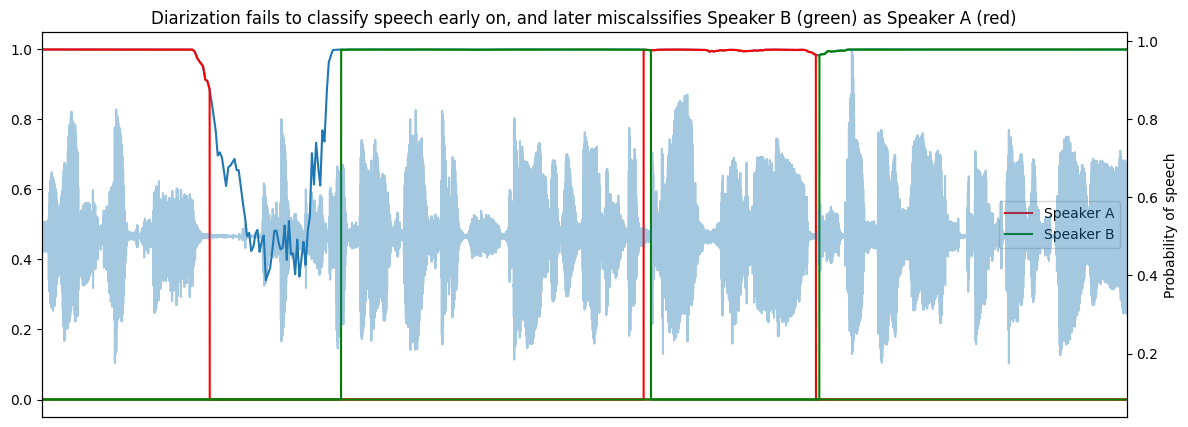

In [83]:
# Plot a window of Voice Activity Detection probability, and a highlighted section within it
def sections(speech_probability, segment, verbose=False):
    if verbose: print(f"Section start {segment[0]:.1f}s, end: {segment[1]:.1f}s")
    start_section_sec = segment[0]
    start_section = int((start_section_sec / duration) * speech_probability.shape[0])
    end_section_sec = segment[1]
    end_section = int((end_section_sec / duration) * speech_probability.shape[0])

    padded = np.zeros((end_entire-start_entire,1))
    padded[start_section-start_entire:end_section-end_entire] = speech_probability[start_section:end_section]
    return padded

s_entire_seconds = 490
start_entire = int((s_entire_seconds / duration) * speech_probability.shape[0])
end_entire_sec = 525
end_entire = int((end_entire_sec / duration) * speech_probability.shape[0])
plt.figure(figsize=(14,5))
plt.plot(speech_probability[start_entire:end_entire,0])

start_section_sec = 500
end_section_sec = 508.854

print(f"Window start {s_entire_seconds:.1f}s, end: {end_entire_sec:.1f}s")
print(f"Section start {start_section_sec:.1f}s, end: {end_section_sec:.1f}s")
padded = sections(speech_probability, (start_section_sec, end_section_sec))

ax = plt.gca()

# Speaker A
plt.plot(padded, color='r', axes=ax)
padded = sections(speech_probability, (512.354, 513.743))
plt.plot(padded, color='r', axes=ax, label='Speaker A')

# Speaker B
padded = sections(speech_probability, (509.914, 512.413))
plt.plot(padded, color='g', axes=ax, label='Speaker B')
padded = sections(speech_probability, (513.771, 521.743))
plt.plot(padded, color='g', axes=ax)
plt.legend()

segment_waveform = crop_waveform(duration, waveform, start_seconds= 490, end_seconds = 525)
segment_waveform = segment_waveform + 0.5
ax.set_xlim(int(segment_waveform.size(-1) * 0.50), 
            int(segment_waveform.size(-1) * 0.75) )

ax2 = ax.twinx()
ax2.plot(segment_waveform, alpha=0.4)
xticks = ax2.get_xticks()
# ax2.set_xlabel("time [second]")
ax2.set_xlim(int(segment_waveform.size(-1) * 0.50), 
             int(segment_waveform.size(-1) * 0.75) )
orig_xticks = s_entire_seconds + (xticks / sample_rate)
dur = end_entire_sec - s_entire_seconds
# plt.xticks(xticks, np.linspace(orig_xticks[0] + dur * 0.5, orig_xticks[0] + dur * 0.75, orig_xticks.shape[0]))
ax.set_xticks([])
# ax.set_xlabel("time [second]")
plt.title(f"Diarization fails to classify speech early on, and later miscalssifies Speaker B (green) as Speaker A (red)")
plt.ylabel("Probability of speech")
plt.show()

## Compare diariazation to Voice activity Detection

Voice activation detection is a sub-task of the diarization pipeline. Though there can be problems in the speaker segmentation & clustering that follows it.

In [ ]:
from pathlib import Path
sys.path.append(str(Path("../scripts").resolve()))

from transcript_analysis import diary_to_frame, time_above_threshold

audio_filepath = test_file
diary_path = "diary.txt"
diary = diary_to_frame(str(diary_path))

last_stop = 0
for index, row in diary.iterrows():
    diary.loc[index, 'time-stop-stop'] = row['stop'] - row['start']
    diary.loc[index, 'vad-stop-stop'] = time_above_threshold(audio_filepath, probability_threshold=0.9, stop=row['stop'], start=last_stop)
    last_stop = row['stop']
diary['speech_ratio'] = diary['vad-stop-stop'] / diary['time-stop-stop']

ix = diary['vad-stop-stop'] > diary['time-stop-stop']
if any(ix):
    display(diary.loc[ix, :])
    print("Since last speaker stopped speaking, more voice was detected than diarized")

## Speaker turns where speaker active time was more than the diarization

In [ ]:
ix = diary['vad-stop-stop'] > diary['time-stop-stop']
if any(ix):
    display(diary.loc[ix, :])
    print("Since last speaker stopped speaking, more voice was detected than diarized")

,start,stop,speaker,time-stop-stop,vad-stop-stop,speech_ratio
16,509.889078,512.346416,Lynne Malcolm,2.457338,2.4638,1.002630
17,512.346416,513.728669,Helen Thomson,1.382253,1.3838,1.001120
46,1331.424915,1348.063140,Lynne Malcolm,16.638225,16.6393,1.000065


Since last speaker stopped speaking, more voice was detected than diarized


### Plot speech probability

* No large periods of low speech probability detected in this example

Text(0.5, 1.0, 'Speech probability across audio')

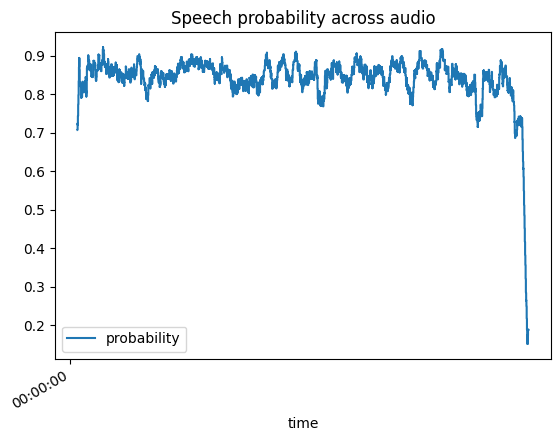

In [ ]:
speech_prob_file = Path("data/interim_01/AIM-1418/speech_probability.csv")
import pandas as pd
data = pd.read_csv(speech_prob_file, header=None)
data.columns = ['time', 'probability']
data.iloc[:,0] = data.iloc[:,0].apply(lambda s: s[:-1]).astype(float)
data = data.set_index('time')
data.index = pd.to_datetime(data.index)
# plot rolling average probability at each 1/10th of a second
sample_rate = 16_000
data.rolling(int(sample_rate / 10)).mean().plot()
plt.title("Speech probability across audio")